## Translation with transformers.

Testing transformer model, which was introduced in the paper [Attention is all you need](https://arxiv.org/pdf/1706.03762.pdf).

The implementation is based in the [Annotated transformer](https://nlp.seas.harvard.edu/2018/04/03/attention.html) blog post.

In [1]:
import os
import random
import math
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

### helpers:

In [6]:
def save_model(model, filename):
    try:
        torch.save(model.state_dict(), filename)
        print('Model saved to %s.' % (filename))
    except:
        raise Exception('The notebook should be run or validated with skip_training=True.')


def load_model(model, filename, device):
    model.load_state_dict(torch.load(filename, map_location=lambda storage, loc: storage))
    print('Model loaded from %s.' % filename)
    model.to(device)
    model.eval()

In [7]:
# KEEP THIS AS TRUE BY DEFAULT -- WILL SKIP TRAINING DURING VALIDATION.
skip_training = True
# skip_training = False
data_dir = "."
#device = torch.device('cuda:0')
device = torch.device('cpu')

In [ ]:
if skip_training:
    # always evaluate on CPU
    device = torch.device("cpu")

## Data

*Make sure you have the data locally, or modify data utils (see old URL comment).*  

If you wish to use the utils for another project, change the hardcoded source in the code or ask me for alternative clean datasets. This translation dataset was provided by Alexander Ilin (larger set also exists, in couple of formats).

In [3]:
# Translation data
from data import TranslationDataset, SOS_token, EOS_token, MAX_LENGTH
trainset = TranslationDataset(data_dir, train=True)

src_seq, tgt_seq = trainset[np.random.choice(len(trainset))]
print('indices: ', src_seq)
print('words: ', ' '.join(trainset.input_lang.index2word[i.item()] for i in src_seq))

indices:  tensor([ 349, 1743,   66, 2422,    5,    1])
words:  ils regardent un film . EOS


## DataLoader

The collate function combines source sequences in one tensor `src_seqs` with extra values (at the end) filled with `PADDING_VALUE=0`. To tell the model which elements are padded, we also need to compute the mask `src_mask`.

The function also combines target sequences in one tensor `tgt_seqs` but it does it a bit differently:
* The resulting tensor is of shape `(max_tgt_seq_length+1, batch_size)`, where `max_tgt_seq_length` is the length of the longest target sequence in the mini-batch.
* The first element of each sequence in the resulting tensor is `SOS_token`.
* The remaining elements are filled similarly to the source sequences with extra values (at the end) filled with `PADDING_VALUE=0`.

In [4]:
from torch.nn.utils.rnn import pad_sequence

PADDING_VALUE = 0

def collate(list_of_samples):
    """Merges a list of samples to form a mini-batch.

    Args:
      list_of_samples is a list of tuples (src_seq, tgt_seq):
          src_seq is of shape (src_seq_length)
          tgt_seq is of shape (tgt_seq_length)

    Returns:
      src_seqs of shape (max_src_seq_length, batch_size): Tensor of padded source sequences.
      src_mask of shape (max_src_seq_length, batch_size): Boolean tensor showing which elements of the
          src_seqs tensor should be ignored in computations (filled with PADDING_VALUE).
      tgt_seqs of shape (max_tgt_seq_length+1, batch_size): Tensor of padded target sequences.
    """
    batch_size = len(list_of_samples)
    
    src_lengths = batch_size*[None]
    tgt_lengths = batch_size*[None]
    
    for index, pair in enumerate(list_of_samples):
        src_lengths[index] = len(pair[0])
        tgt_lengths[index] = len(pair[1])
        
    max_src_len = np.max(src_lengths)
    max_tgt_len = np.max(tgt_lengths)
    
    src_seqs = torch.empty((max_src_len,batch_size),dtype=torch.long)
    tgt_seqs = torch.empty((max_tgt_len,batch_size),dtype=torch.long)
    
    i = 0
    for s,t in list_of_samples:
        src_seqs[:,i] = F.pad(s,pad=[0,max_src_len-len(s)], value=PADDING_VALUE)
        tgt_seqs[:,i] = F.pad(t,pad=[0,max_tgt_len-len(t)], value=PADDING_VALUE)
        i+=1
        
    token_col = SOS_token*torch.ones((1, tgt_seqs.size(1)),dtype=torch.long)
    tgt_seqs = torch.cat((token_col,tgt_seqs),0)
    
    src_mask = torch.arange(max_src_len)[:,None] < torch.tensor(src_lengths)[None,:]
    
    return src_seqs, ~src_mask, tgt_seqs


In [10]:
# DataLoader (batch_size=64)
trainloader = DataLoader(dataset=trainset, batch_size=64, shuffle=True, collate_fn=collate, pin_memory=True)

## Encoder block

One block of the transformer encoder.
* [nn.LayerNorm](https://pytorch.org/docs/stable/nn.html#torch.nn.LayerNorm) to implement the `Norm` layer in the figure
* [nn.Dropout](https://pytorch.org/docs/stable/nn.html#torch.nn.Dropout) to implement dropout
* [nn.MultiheadAttention](https://pytorch.org/docs/stable/nn.html?highlight=multiheadattention#torch.nn.MultiheadAttention) to implement `Multi-Head Attention`.

`Feedforward` is simply an MLP processing each element of the source sequence independently.
* one hidden layer with `n_hidden` neurons
* a dropout and ReLU activation after the hidden layer
* an output layer with `n_features` outputs.


* Using dropout in both skip connections of the encoder block.

(*slightly different to the [Annotated transformer](https://nlp.seas.harvard.edu/2018/04/03/attention.html) code*)


In [11]:

class FeedForward(nn.Module):
    def __init__(self, n_features, n_hidden, dropout = 0.1):
        super().__init__() 
        self.linear1 = nn.Linear(n_features, n_hidden)
        self.drop = nn.Dropout(dropout)
        self.linear2 = nn.Linear(n_hidden, n_features)
    def forward(self, x):
        x = self.drop(F.relu(self.linear1(x)))
        x = self.linear2(x)
        return x

class EncoderBlock(nn.Module):
    def __init__(self, n_features, n_heads, n_hidden=64, dropout=0.1):
        """
        Args:
          n_features: Number of input and output features.
          n_heads: Number of attention heads in the Multi-Head Attention.
          n_hidden: Number of hidden units in the Feedforward (MLP) block.
          dropout: Dropout rate after the first layer of the MLP and in two places on the main path (before
                   combining the main path with a skip connection).
        """
        super(EncoderBlock, self).__init__()
        # NOTE: the redundancy in drop,skip layers is for clarity when coding the block
        self.norm1 = nn.LayerNorm(n_features, eps=1e-6)
        self.norm2 = nn.LayerNorm(n_features, eps=1e-6)
        self.drop1 = nn.Dropout(dropout)
        self.drop2 = nn.Dropout(dropout)
        self.skip1 = nn.Identity()
        self.skip2 = nn.Identity()
        self.attn = nn.MultiheadAttention(embed_dim= n_features, num_heads=n_heads)
        self.ff = FeedForward(n_features, n_hidden, dropout)
        

    def forward(self, x, mask):
        """
        Args:
          x of shape (max_seq_length, batch_size, n_features): Input sequences.
          mask of shape (batch_size, max_seq_length): Boolean tensor indicating which elements of the input
              sequences should be ignored.
        
        Returns:
          z of shape (max_seq_length, batch_size, n_features): Encoded input sequence.
        """
        x0 = self.skip1(x)
        x,_ = self.attn(x,x,x, mask)
        x = self.norm1(x0 + self.drop1(x))
        x1 = self.skip2(x)
        x = self.ff(x)
        x = self.norm2(x1 + self.drop2(x))
        
        return x
        


## Encoder

The encoder is a stack of the following blocks:
* Embedding of words (please use [nn.Embedding](https://pytorch.org/docs/stable/nn.html#torch.nn.Embedding))
* Positional encoding.
* `n_blocks` of the `EncoderBlock` modules.

Notes:
* The `PositionalEncoding` is the same as in [Annotated transformer](https://nlp.seas.harvard.edu/2018/04/03/attention.html) blog post.

In [12]:
'''
from copy import deepcopy
def clones(module, N):
    "Produce N identical blocks."
    return nn.ModuleList([deepcopy(module) for _ in range(N)])
'''
class PositionalEncoding(nn.Module):
    """This implementation is the same as in the Annotated transformer blog post
        See https://nlp.seas.harvard.edu/2018/04/03/attention.html for more detail.
    """
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        assert (d_model % 2) == 0, 'The embedding dim should be an even number.'
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)


class PEEmbed(nn.Module):
    def __init__(self, src_vocab_size, n_features, dropout=0.1):
        super(PEEmbed, self).__init__()
        
        self.embedding = nn.Embedding(src_vocab_size, n_features)
        self.pe = PositionalEncoding(n_features, dropout, MAX_LENGTH)
        
    def forward(self, pad_seqs):
        """
        Args:
          pad_seqs of shape (max_seq_length, batch_size): Padded source sequences.
          seq_lengths: List of sequence lengths.
          hidden of shape (1, batch_size, hidden_size): Initial states of the GRU.

        Returns:
          outputs of shape (max_seq_length, batch_size, hidden_size): Padded outputs of GRU at every step.
          hidden of shape (1, batch_size, hidden_size): Updated states of the GRU.
        """
        pee = self.pe(self.embedding(pad_seqs))
        return pee

        
class Encoder(nn.Module):
    def __init__(self, src_vocab_size, n_blocks, n_features, n_heads, n_hidden=64, dropout=0.1):
        """
        Args:
          src_vocab_size: Number of words in the source vocabulary.
          n_blocks: Number of EncoderBlock blocks.
          n_features: Number of features to be used for word embedding and further in all layers of the encoder.
          n_heads: Number of attention heads inside the EncoderBlock.
          n_hidden: Number of hidden units in the Feedforward block of EncoderBlock.
          dropout: Dropout level used in EncoderBlock.
        """
        super(Encoder, self).__init__()
        self.pee = PEEmbed(src_vocab_size, n_features, dropout)
        #self.blocks = clones(EncoderBlock(n_features, n_heads, n_hidden, dropout),n_blocks)
        self.blocks = nn.ModuleList([EncoderBlock(n_features, n_heads, n_hidden, dropout) \
                                     for _ in range(n_blocks)])
        

    def forward(self, x, mask):
        """
        Args:
          x of shape (max_seq_length, batch_size): LongTensor with the input sequences.
          mask of shape (batch_size, max_seq_length): BoolTensor indicating which elements should be ignored.
        
        Returns:
          z of shape (max_seq_length, batch_size, n_features): Encoded input sequence.
        """
        x = self.pee(x)
        for block in self.blocks:
            x = block(x, mask)
        return x
        

# Decoding

## Subsequent mask

In the training loop, target sequences (starting with `SOS_token`) are passed as inputs for the decoder. Doing that allows the decoder to use previously decoded words when predicting probabilities of the next word. 

During decoding, we need to make sure that when we compute the probability of the next word, we only use preceding and not subsequent words. This is can be done by masking the "unseen" data.

The $i$-th row in the produced mask says which of the input elements should be used to compute the $i$-th element of the output:
* `0`: the corresponding element of the input sequence can be used.
* `-inf`: the corresponding element of the input sequence cannot be used.

In [13]:
def subsequent_mask(sz):
    mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1).float()
    mask = mask.masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask

tensor([[0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])


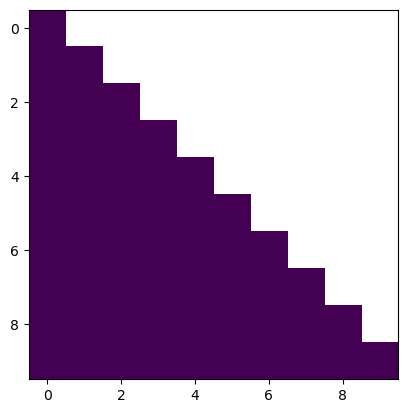

In [14]:
# To get the idea of the mask
mask = subsequent_mask(10)
print(mask)
plt.imshow(mask)

## Decoder block

* [nn.LayerNorm](https://pytorch.org/docs/stable/nn.html#torch.nn.LayerNorm) to implement the `Norm` layer in the figure
* [nn.Dropout](https://pytorch.org/docs/stable/nn.html#torch.nn.Dropout) to implement dropout
* [nn.MultiheadAttention](https://pytorch.org/docs/stable/nn.html?highlight=multiheadattention#torch.nn.MultiheadAttention) to implement `Multi-Head Attention`.

`Feedforward` is again simply an MLP processing each position. The model seems to do fine with fairly simple implementation.
  * one hidden layer with `n_hidden` neurons
  * a dropout and ReLU activation after the hidden layer
  * an output layer with `n_features` outputs.

* where skip connections are used, dropout is applied on the main path, and then (after combining) layer normalization is applied. This order is slightly different to the [Annotated transformer](https://nlp.seas.harvard.edu/2018/04/03/attention.html) code.

Notes:
* The first attention block is self-attention when query, key and value inputs are same. The second attention block uses the encoded `z` values as keys and values, and the outputs of the previous layer as query.


In [15]:
class DecoderBlock(nn.Module):
    def __init__(self, n_features, n_heads, n_hidden=64, dropout=0.1):
        """
        Args:
          n_features: Number of input and output features.
          n_heads: Number of attention heads in the Multi-Head Attention.
          n_hidden: Number of hidden units in the Feedforward (MLP) block.
          dropout: Dropout rate after the first layer of the MLP and in three places on the main path (before
                   combining the main path with a skip connection).
        """
        super(DecoderBlock, self).__init__()
        self.norm1 = nn.LayerNorm(n_features, eps=1e-6)
        self.norm2 = nn.LayerNorm(n_features, eps=1e-6)
        self.norm3 = nn.LayerNorm(n_features, eps=1e-6)
        self.drop1 = nn.Dropout(dropout)
        self.drop2 = nn.Dropout(dropout)
        self.drop3 = nn.Dropout(dropout)
        self.skip1 = nn.Identity()
        self.skip2 = nn.Identity()
        self.skip3 = nn.Identity()
        self.attn1 = nn.MultiheadAttention(embed_dim= n_features, num_heads=n_heads)
        self.attn2 = nn.MultiheadAttention(embed_dim= n_features, num_heads=n_heads)
        self.ff = FeedForward(n_features, n_hidden, dropout)

    def forward(self, y, z, src_mask, tgt_mask):
        """
        Args:
          y of shape (max_tgt_seq_length, batch_size, n_features): Transformed target sequences used as the inputs
              of the block.
          z of shape (max_src_seq_length, batch_size, n_features): Encoded source sequences (outputs of the
              encoder).
          src_mask of shape (batch_size, max_src_seq_length): Boolean tensor indicating which elements of the
             source sequences should be ignored.
          tgt_mask of shape (max_tgt_seq_length, max_tgt_seq_length): Subsequent mask to ignore subsequent
             elements of the target sequences in the inputs. The rows of this matrix correspond to the output
             elements and the columns correspond to the input elements.
        
        Returns:
          z of shape (max_seq_length, batch_size, n_features): Output tensor.
        """
        y0 = self.skip1(y)
        y,_ = self.attn1(y, y, y, attn_mask= tgt_mask)
        y = self.norm1(y0 + self.drop1(y))
        y1 = self.skip2(y)
        y,_ = self.attn2(y,z,z,key_padding_mask= src_mask)
        y = self.norm2(y1 + self.drop2(y))
        y2 = self.skip3(y)
        y = self.ff(y)
        y = self.norm3(y2 + self.drop3(y))
        
        return y
        
        


## Decoder

The decoder is a stack of the following blocks:
* Embedding of words (please use [nn.Embedding](https://pytorch.org/docs/stable/nn.html#torch.nn.Embedding))
* Positional encoding (please use `tr.PositionalEncoding` from the attached module)
* `n_blocks` of the `DecoderBlock` modules.
* A linear layer with `tgt_vocab_size` output features.
* Log_softmax nonlinearity.

Note: our longest sequences have length `MAX_LENGTH`, (specify for `PositionalEncoding`).

In [16]:
class Decoder(nn.Module):
    def __init__(self, tgt_vocab_size, n_blocks, n_features, n_heads, n_hidden=64, dropout=0.1):
        """
        Args:
          tgt_vocab_size: Number of words in the target vocabulary.
          n_blocks: Number of EncoderBlock blocks.
          n_features: Number of features to be used for word embedding and further in all layers of the decoder.
          n_heads: Number of attention heads inside the DecoderBlock.
          n_hidden: Number of hidden units in the Feedforward block of DecoderBlock.
          dropout: Dropout level used in DecoderBlock.
        """
        super(Decoder, self).__init__()
        self.pee = PEEmbed(tgt_vocab_size, n_features, dropout)
        #self.blocks = clones(DecoderBlock(n_features, n_heads, n_hidden, dropout),n_blocks)
        self.blocks = nn.ModuleList([DecoderBlock(n_features, n_heads, n_hidden, dropout) for _ in range(n_blocks)])
        self.linear = nn.Linear(n_features, tgt_vocab_size)
        
    def forward(self, y, z, src_mask):
        """
        Args:
          y of shape (max_tgt_seq_length, batch_size): Transformed target sequences used as the inputs
              of the block.
          z of shape (max_src_seq_length, batch_size, n_features): Encoded source sequences (outputs of the
              encoder).
          src_mask of shape (batch_size, max_src_seq_length): Boolean tensor indicating which elements of the
             source sequences should be ignored.
        
        Returns:
          out of shape (max_seq_length, batch_size, tgt_vocab_size): Log-softmax probabilities of the words
              in the output sequences.
        """
        dev = y.device
        tgt_mask = subsequent_mask(y.size(0)).to(device)
        y = self.pee(y)
        for block in self.blocks:
            y = block(y, z, src_mask, tgt_mask)
        out = self.linear(y)
        
        return F.log_softmax(out, dim=2)
        

## Model init

In [17]:
# Create the transformer model
n_features = 256
encoder = Encoder(src_vocab_size=trainset.input_lang.n_words, n_blocks=3, n_features=n_features,
                  n_heads=16, n_hidden=1024)
decoder = Decoder(tgt_vocab_size=trainset.output_lang.n_words, n_blocks=3, n_features=n_features,
                  n_heads=16, n_hidden=1024)

encoder.to(device)
decoder.to(device)

Decoder(
  (pee): PEEmbed(
    (embedding): Embedding(2925, 256)
    (pe): PositionalEncoding(
      (dropout): Dropout(p=0.1, inplace=False)
    )
  )
  (blocks): ModuleList(
    (0-2): 3 x DecoderBlock(
      (norm1): LayerNorm((256,), eps=1e-06, elementwise_affine=True)
      (norm2): LayerNorm((256,), eps=1e-06, elementwise_affine=True)
      (norm3): LayerNorm((256,), eps=1e-06, elementwise_affine=True)
      (drop1): Dropout(p=0.1, inplace=False)
      (drop2): Dropout(p=0.1, inplace=False)
      (drop3): Dropout(p=0.1, inplace=False)
      (skip1): Identity()
      (skip2): Identity()
      (skip3): Identity()
      (attn1): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
      )
      (attn2): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
      )
      (ff): FeedForward(
        (linear1): Linear(in_features=256, out_features=1024, bias=T

### Optimizer

Testing the `NoamOptimizer`. Standard optimizers like Adam, are more prone to hitting plateaus.

In [ ]:
class NoamOptimizer:
    """
    Optim wrapper that implements rate.
    The learning rate is defined by the model size, the warmup and the step.
    """
    def __init__(self, model_size, factor, warmup, optimizer):
        self.optimizer = optimizer
        self._step = 0
        self.warmup = warmup
        self.factor = factor
        self.model_size = model_size
        self._rate = 0
        
    def step(self):
        """
        Update parameters and rate.
        """
        self._step += 1
        rate = self.rate()
        for p in self.optimizer.param_groups:
            p['lr'] = rate
        self._rate = rate
        self.optimizer.step()
        
    def rate(self, step = None):
        """
        Implement `lrate` above
        """
        if step is None:
            step = self._step
        return self.factor * \
            (self.model_size ** (-0.5) *
            min(step ** (-0.5), step * self.warmup ** (-1.5)))
    
    def zero_grad(self):
        self.optimizer.zero_grad()

In [ ]:
parameters = list(encoder.parameters()) + list(decoder.parameters())
adam = torch.optim.Adam(parameters, lr=0, betas=(0.9, 0.98), eps=1e-9)
optimizer = NoamOptimizer(n_features, 2, 10000, adam)

In [18]:
trainloader = DataLoader(dataset=trainset, batch_size=64, shuffle=True, collate_fn=collate, pin_memory=True)

### Training loop

In the training loop, we first encode source sequences using the encoder. Then we decode the encoded sequences by the decoder which also receives shifted target sequences as inputs. The decoder outputs a tensor that contains log-softmax probabilities of words in the output language.


In [ ]:
if not skip_training:
    n_epochs = 40
    for i in range(n_epochs):
        encoder.train()
        decoder.train()
        epoch_loss = []

        for s, s_mask_T, t in trainloader:
            s = s.to(device)
            t = t.to(device)
            s_mask = s_mask_T.transpose(0,1).to(device)
            optimizer.zero_grad()
            z = encoder(s, s_mask)
            yhat = decoder(t[:-1],z, s_mask)
            loss = F.nll_loss(yhat.permute(1,2,0),t[1:].permute(1,0),\
                                  ignore_index=0, reduction = 'mean')#, reduce=True,size_average=True)

            epoch_loss.append(loss.item())
            loss.backward()
            optimizer.step()
        print(np.mean(epoch_loss))


In [19]:
if not skip_training:
    save_model(encoder, 'tr_encoder.pth')
    save_model(decoder, 'tr_decoder.pth')
else:
    encoder = Encoder(src_vocab_size=trainset.input_lang.n_words, n_blocks=3, n_features=256, n_heads=16, n_hidden=1024)
    load_model(encoder, 'tr_encoder.pth', device)
    
    decoder = Decoder(tgt_vocab_size=trainset.output_lang.n_words, n_blocks=3, n_features=256, n_heads=16, n_hidden=1024)
    load_model(decoder, 'tr_decoder.pth', device)

Model loaded from tr_encoder.pth.
Model loaded from tr_decoder.pth.


## Generate translations with the trained model

In [20]:
def translate(encoder, decoder, src_seq):
    """
    Args:
      encoder (Encoder): Trained encoder.
      decoder (Decoder): Trained decoder.
      src_seq of shape (src_seq_length): LongTensor of word indices of the source sentence.
    
    Returns:
      out_seq of shape (out_seq_length, 1): LongTensor of word indices of the output sentence.
    """
    encoder.eval()
    decoder.eval()
    src_seq = src_seq.view(-1,1)
    src_mask = (src_seq==EOS_token).view(1,-1)
    memory = encoder(src_seq, src_mask)
    
    prev_words = SOS_token*torch.ones(1, 1).type_as(src_seq.data)
    for i in range(MAX_LENGTH):
        prob = decoder(prev_words, memory, src_mask)
        _, next_word = torch.max(prob, dim = 2)
        next_word = next_word.data[i]
        prev_words = torch.cat([prev_words,next_word*torch.ones(1, 1).type_as(src_seq.data)], dim=0)
        
        if next_word==EOS_token:
            break
    
    return prev_words[1:]
    

Below, we translate sentences from the *training* set. The translations look ~similar to the target sentences.

In [21]:
print('Translate training data:')
print('-----------------------------')
for i in range(5):
    src_sentence, tgt_sentence = trainset[np.random.choice(len(trainset))]
    print('>', ' '.join(trainset.input_lang.index2word[i.item()] for i in src_sentence))
    print('=', ' '.join(trainset.output_lang.index2word[i.item()] for i in tgt_sentence))
    out_sentence = translate(encoder, decoder, src_sentence)
    print('<', ' '.join(trainset.output_lang.index2word[i.item()] for i in out_sentence), '\n')

Translate training data:
-----------------------------
> je n en suis pas fier . EOS
= i m not proud of that . EOS
< i m not proud of this . EOS 

> nous sommes tous deux ecrivains . EOS
= we re both writers . EOS
< we re both writers . EOS 

> elle est toujours habillee en noir . EOS
= she is always dressed in black . EOS
< she is always dressed in black . EOS 

> je te vois sous un nouveau jour . EOS
= i m seeing you in a new light . EOS
< i m seeing you in a new light . EOS 

> vous avez parfaitement raison . EOS
= you re absolutely right . EOS
< you re totally right . EOS 



Now sentences from the test set. The translations are typically
worse than for the training sequences but they still look reasonable.

In [22]:
testset = TranslationDataset(data_dir, train=False)

In [23]:
print('Translate test data:')
print('-----------------------------')
for i in range(5):
    input_sentence, target_sentence = testset[np.random.choice(len(testset))]
    print('>', ' '.join(testset.input_lang.index2word[i.item()] for i in input_sentence))
    print('=', ' '.join(testset.output_lang.index2word[i.item()] for i in target_sentence))
    output_sentence = translate(encoder, decoder, input_sentence)
    print('<', ' '.join(testset.output_lang.index2word[i.item()] for i in output_sentence), '\n')

Translate test data:
-----------------------------
> je suis reellement fier de toi . EOS
= i m really proud of you . EOS
< i m really proud of you . EOS 

> elle est un peu niaise . EOS
= she s a bit naive . EOS
< she s a bit jealous . EOS 

> nous sommes cousines . EOS
= we re cousins . EOS
< we re the owners . EOS 

> nous n en sommes pas si sures . EOS
= we re not so sure . EOS
< we re not so so sure . EOS 

> tu es partiale . EOS
= you re biased . EOS
< you re clever . EOS 

